In [1]:
from copy import copy
from time import time

import matplotlib.pyplot as plt
import pandas as pd

from HARK.Calibration.Income.IncomeTools import (
    CGM_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.ConsumptionSaving.ConsBequestModel import (
    BequestWarmGlowConsumerType,
    init_warm_glow,
)
from HARK.datasets.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.datasets.SCF.WealthIncomeDist.SCFDistTools import income_wealth_dists_from_scf
from HARK.utilities import plot_funcs

In [2]:
birth_age = 25
death_age = 90
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to, age=birth_age, education=education, wave=1995
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True, cross_sec=True, year=2004, min_age=birth_age, max_age=death_age - 1
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_warm_glow)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params.update({"LivPrb": [1.0] * len(liv_prb)})

In [3]:
# Make and solve an idiosyncratic shocks consumer with a finite lifecycle
TerminalExample = BequestWarmGlowConsumerType(**params)
# Make this consumer live a sequence of periods exactly once
TerminalExample.cycles = 1

In [4]:
start_time = time()
TerminalExample.solve()
end_time = time()
print(f"Solving a lifecycle consumer took {end_time - start_time} seconds.")
TerminalExample.unpack("cFunc")

Solving a lifecycle consumer took 0.5033817291259766 seconds.


Consumption functions


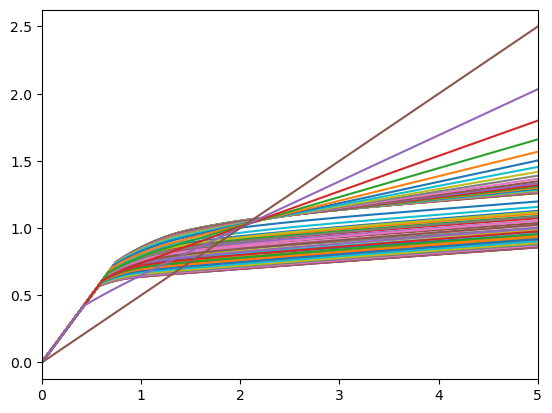

In [5]:
# Plot the consumption functions
print("Consumption functions")
plot_funcs(TerminalExample.cFunc, 0, 5)

In [6]:
# Number of LifecycleExamples and periods in the simulation.
TerminalExample.AgentCount = 500
TerminalExample.T_sim = 200

# Set up the variables we want to keep track of.
TerminalExample.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm"]

# Run the simulations
TerminalExample.initialize_sim()
TerminalExample.simulate()

{'aNrm': array([[0.29180317, 0.97445584, 0.36040378, ..., 1.79332645, 2.87342647,
         0.24466457],
        [0.24197944, 0.97645683, 0.6442841 , ..., 1.74578226, 1.86103899,
         0.14921818],
        [0.61664841, 1.91975561, 0.63314946, ..., 1.43299487, 2.6504932 ,
         0.97807016],
        ...,
        [2.57121847, 0.23619627, 0.23789935, ..., 0.51954935, 5.05662923,
         0.44677126],
        [3.01728285, 0.22740195, 0.43379262, ..., 1.01764029, 5.0196123 ,
         0.38871327],
        [3.6414104 , 0.39773907, 0.76229044, ..., 2.21032915, 3.25887889,
         0.4625948 ]]),
 'cNrm': array([[0.8310167 , 0.93240488, 0.84951983, ..., 0.99504093, 1.06639246,
         0.81566228],
        [0.80468688, 0.91627163, 0.88342012, ..., 0.97278283, 0.98051186,
         0.76660798],
        [0.87044306, 0.96997463, 0.87244477, ..., 0.93803717, 1.0155411 ,
         0.90484725],
        ...,
        [1.01069925, 0.79677493, 0.7973765 , ..., 0.85792327, 1.15653244,
         0.8468094

In [7]:
raw_data = {
    "Age": TerminalExample.history["t_age"].flatten() + birth_age - 1,
    "pIncome": TerminalExample.history["pLvl"].flatten(),
    "nrmM": TerminalExample.history["mNrm"].flatten(),
    "nrmC": TerminalExample.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

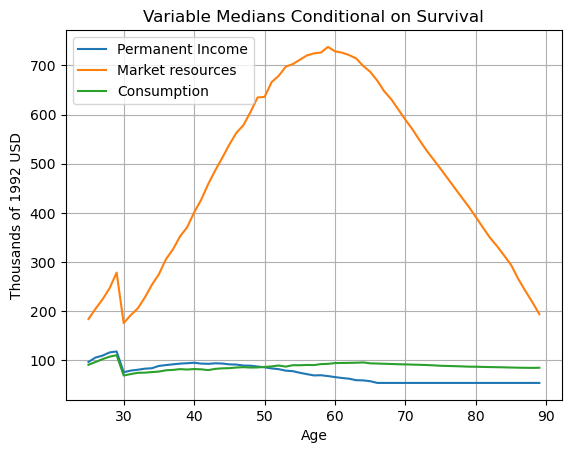

In [8]:
# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Thousands of {} USD".format(adjust_infl_to))
plt.title("Variable Medians Conditional on Survival")
plt.grid()